In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tqdm import tqdm
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

In [2]:
df = pd.read_csv("./train_text.csv")

In [3]:
df

,id,description,price
0,7310804917,This 2017 Ford F-150 Lariat 4WD SuperCrew 5.5'...,1.413851
1,7310280162,2016 Ford F-250 Super Duty XL 4x4 4dr Crew Cab...,1.114045
2,7306277173,Carvana is the safer way to buy a car During t...,0.840341
3,7303579544,2OO8 FORD F/15O SPORT PICKUP EXTENDED CAB W/ ...,-0.789005
4,7316342608,Lundgren Subaru address: 527 N. Bennington ...,0.518638
...,...,...,...
242612,7316439366,2018 Toyota Camry SE - (Celestial Silver Metal...,0.385342
242613,7310781418,Broadmoor MotorsAsk for: Paul Murphy☎ (616) 31...,0.290943
242614,7307615458,54!!!!! detailed ASE Certified service records...,-0.387448
242615,7316779292,"2013 VW Jetta SE 2.5L 5-speed, A/C, pwr. windo...",-0.982714


In [4]:
process_pipeline = []

In [5]:
#Observe many samples come from carvana
#Perform a simple regex filter


In [6]:
def transform1(df):
    df["from_carvana"] = np.where(df["description"].apply(lambda x: bool(re.match(r"carvana", x.lower()))), 1, 0)
transform1(df)
process_pipeline.append(transform1)

In [7]:
df["from_carvana"].value_counts()

from_carvana
0    196530
1     46087
Name: count, dtype: int64

<Axes: xlabel='from_carvana', ylabel='count'>

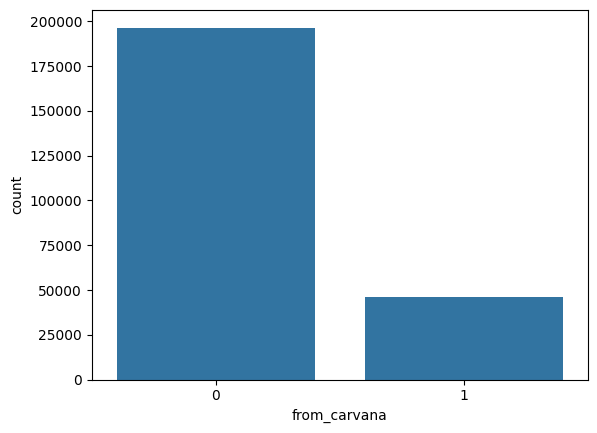

In [8]:
sns.countplot(df, x='from_carvana')

<Axes: xlabel='from_carvana', ylabel='price'>

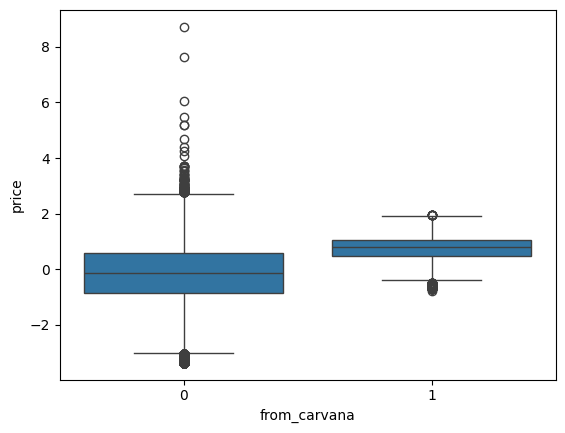

In [9]:
sns.boxplot(data=df, y='price', x='from_carvana')

Cars from carvana tend to have higher prices

Perform some basic cleaning i.e. removing urls, non-ascii chars, extra spaces, stopword removal, tokenization, lemmatization

In [54]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
lemmatizer = WordNetLemmatizer()
stop_words = set(nltk.corpus.stopwords.words('english'))
url_non_asciipattern = re.compile(r'https?://[^\s]+|www\.[^\s]+|[^\w\s]+$')
punctuation_pattern = re.compile(r'(?<!\d)[^\w\s]+(?!\d)|\s*,\s*')
space_pattern = re.compile(r'\s+')

def clean_string(text):
    text = text.lower()
    stripped_text = url_non_asciipattern.sub('', text)
    stripped_text = punctuation_pattern.sub('', stripped_text)
    stripped_text = space_pattern.sub(' ', stripped_text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in word_tokenize(stripped_text) if word not in stop_words]
    return ' '.join(lemmatized_words)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ashley\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ashley\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ashley\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [55]:
input_text = "2.4L Check out this link: https://example.com, and also visit! 3,t 3, 400 3,200www.example.org!!! 2 40 😊"
result = clean_string(input_text)
print(result)  # Output: "Check out this link and also visit"


2.4l check link also visit 3t 3400 3200 2 40


In [56]:
tqdm.pandas()
def transform2(df):
    df['description'] = df['description'].progress_apply(clean_string)
transform2(df)
process_pipeline.append(transform2)

100%|██████████| 242617/242617 [06:49<00:00, 592.60it/s]


In [57]:
df

,id,description,price,from_carvana
0,7310804917,2017 ford f-150 lariat 4wd supercrew 5.5 ' box...,1.413851,0
1,7310280162,2016 ford f-250 super duty xl 4x4 4dr crew cab...,1.114045,0
2,7306277173,carvana safer way buy car uncertain time carva...,0.840341,1
3,7303579544,2oo8 ford f/15o sport pickup extended cab w re...,-0.789005,0
4,7316342608,lundgren subaru address 527 n bennington rd be...,0.518638,0
...,...,...,...,...
242612,7316439366,2018 toyota camry se celestial silver metallic...,0.385342,0
242613,7310781418,broadmoor motorsask paul murphy ( 616 ) 318-77...,0.290943,0
242614,7307615458,54 ! detailed ase certified service record rec...,-0.387448,0
242615,7316779292,2013 vw jetta se 2.5l 5-speed ac pwr window pw...,-0.982714,0


In [92]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [64]:
tfidf = TfidfVectorizer(max_df = 0.95, min_df = 0.05)#Prune those that exist less than 5% of the time and those that exists more than 95% of the time to reduce the number of features

In [65]:
out = tfidf.fit_transform(df['description'])

In [66]:
out

<242617x703 sparse matrix of type '<class 'numpy.float64'>'
	with 29863474 stored elements in Compressed Sparse Row format>

In [93]:
#No need to reduce dimensions of our data since number of datapoints >> number of features

In [61]:
test = pd.read_csv("./testval_text.csv")

In [62]:
for transform in process_pipeline:
    transform(test)

100%|██████████| 60576/60576 [01:50<00:00, 547.87it/s]


In [86]:
test_data = tfidf.transform(test['description'])

Merge our tfidf data to main df

In [96]:
df

,id,description,price,from_carvana
0,7310804917,2017 ford f-150 lariat 4wd supercrew 5.5 ' box...,1.413851,0
1,7310280162,2016 ford f-250 super duty xl 4x4 4dr crew cab...,1.114045,0
2,7306277173,carvana safer way buy car uncertain time carva...,0.840341,1
3,7303579544,2oo8 ford f/15o sport pickup extended cab w re...,-0.789005,0
4,7316342608,lundgren subaru address 527 n bennington rd be...,0.518638,0
...,...,...,...,...
242612,7316439366,2018 toyota camry se celestial silver metallic...,0.385342,0
242613,7310781418,broadmoor motorsask paul murphy ( 616 ) 318-77...,0.290943,0
242614,7307615458,54 ! detailed ase certified service record rec...,-0.387448,0
242615,7316779292,2013 vw jetta se 2.5l 5-speed ac pwr window pw...,-0.982714,0


In [101]:
#copy new id column to merge our new df
df['id_copy']=df['id']

In [116]:
df[['id_copy', 'from_carvana']].join(pd.DataFrame(out.toarray(), columns=tfidf.get_feature_names_out())).to_csv("train_processed_text.csv", index=False)

In [105]:
test['id_copy']=test['id']

In [106]:
from sklearn.model_selection import train_test_split

In [107]:
test

,id,description,price,from_carvana,id_copy
0,7315883828,carvana safer way buy car uncertain time carva...,1.117065,1,7315883828
1,7308399808,want see picturespaste link view detailed phot...,2.048692,0,7308399808
2,7309863303,2002 chrysler town country dan deery motor sto...,-2.107785,0,7309863303
3,7315163492,2015 mitsubishi outlander sport e suv fwd goal...,0.022061,0,7315163492
4,7304728134,used car sale going shahani motor limited time...,-1.494535,0,7304728134
...,...,...,...,...,...
60571,7312879514,mileage 99007 body suv drivetrain awd exterior...,-0.097234,0,7312879514
60572,7316392642,carvana safer way buy car uncertain time carva...,0.390773,1,7316392642
60573,7314862430,2015 chrysler town country touring 3.6l v6104k...,-1.137884,0,7314862430
60574,7316839788,run excellent 6 cyl automatic cold ac power wi...,-2.150999,0,7316839788


In [108]:
test_new = test[['id_copy', 'from_carvana']].join(pd.DataFrame(test_data.toarray(), columns=tfidf.get_feature_names_out()))

In [109]:
test_new

,id_copy,from_carvana,00,01,02,03,04,05,06,07,...,whiteinterior,window,wiper,without,wont,work,year,youdisclaimer,youre,zone
0,7315883828,1,0.015523,0.016683,0.016672,0.016661,0.016601,0.016519,0.016361,0.016549,...,0.026487,0.000000,0.0,0.029644,0.016685,0.013340,0.000000,0.017921,0.000000,0.000000
1,7308399808,0,0.059094,0.015877,0.015867,0.015857,0.015799,0.015721,0.015571,0.015750,...,0.000000,0.014144,0.0,0.000000,0.000000,0.000000,0.026217,0.000000,0.000000,0.023178
2,7309863303,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.049002,0.000000,0.089125,0.000000
3,7315163492,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.033155,0.017117,0.000000,0.000000,0.000000
4,7304728134,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.055652,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60571,7312879514,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
60572,7316392642,1,0.039629,0.042590,0.042562,0.042535,0.042381,0.042172,0.041769,0.042249,...,0.067618,0.000000,0.0,0.075679,0.042595,0.068109,0.000000,0.045751,0.000000,0.000000
60573,7314862430,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
60574,7316839788,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.182206,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [110]:
#Copy same state from eda_part2 to generate same split
test_set, val_set = train_test_split(test_new, test_size=0.5, random_state=42)

In [114]:
test_set.to_csv("test_processed_text.csv",index=False)

In [115]:
val_set.to_csv("val_processed_text.csv", index=False)